In [25]:

from dataset.augmentation import AugmentationDatasetSelector, AugmentationDataset
from dataset.get_tdc_dataset import get_tdc_dataset

name = 'HIA_Hou'
root = './TDC_Dataset'

data_dict = get_tdc_dataset(name, root)

# print(data_list)
train_data = data_dict['train']
print(train_data[:5])
train_smiles = [data['smiles'] for data in train_data]
train_y = [data['y'].item() for data in train_data]
print(train_smiles[:5])
print(train_y[:5])

augment_selector = AugmentationDatasetSelector(name = name , root = root, smiles_list = train_smiles, y_list = train_y)

cluster_ids = augment_selector.scaffold_clustering(cutoff=0.4)

sampled_smiles_df = augment_selector.augmentation_sampling(N = 100, seed = 42)
sampled_smiles = sampled_smiles_df['smiles'].tolist()

selected_data = AugmentationDataset(name = name, root = root, smiles_list = sampled_smiles,
                                    )

for i in range(5):
    print(selected_data[i])
    print(selected_data[i]['node_mask'])
    break
    

Found local copy...
Loading...
Done!
100%|██████████| 578/578 [00:00<00:00, 4344.18it/s]


Processing train set
Processing valid set
Processing test set
[Data(x=[10, 14], edge_index=[2, 20], edge_attr=[20, 7], num_nodes=[1], num_edges=20, smiles='CC(=O)Nc1ccccc1', y=[1]), Data(x=[24, 14], edge_index=[2, 48], edge_attr=[48, 7], num_nodes=[1], num_edges=48, smiles='COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=CC(=O)O)c(C)c1C', y=[1]), Data(x=[19, 14], edge_index=[2, 38], edge_attr=[38, 7], num_nodes=[1], num_edges=38, smiles='CC(C)NC[C@H](O)COc1ccc(CC(N)=O)cc1', y=[1]), Data(x=[15, 14], edge_index=[2, 30], edge_attr=[30, 7], num_nodes=[1], num_edges=30, smiles='CC(C)Cc1ccc([C@H](C)C(=O)O)cc1', y=[1]), Data(x=[16, 14], edge_index=[2, 32], edge_attr=[32, 7], num_nodes=[1], num_edges=32, smiles='CCNC[C@H](C)c1cccc(C(F)(F)F)c1', y=[1])]
['CC(=O)Nc1ccccc1', 'COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=CC(=O)O)c(C)c1C', 'CC(C)NC[C@H](O)COc1ccc(CC(N)=O)cc1', 'CC(C)Cc1ccc([C@H](C)C(=O)O)cc1', 'CCNC[C@H](C)c1cccc(C(F)(F)F)c1']
[1.0, 1.0, 1.0, 1.0, 1.0]
Clustered 404 training data into 245 clusters.
Unique clus

Processing...
100%|██████████| 100/100 [00:00<00:00, 584.96it/s]

Data(x=[23, 11], edge_index=[2, 50], edge_attr=[50, 5], y=[1, 0], idx=[1], edge_mask=[50], node_mask=[23])
tensor([False,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True])



Done!


In [24]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
import torch

def test_scaffold_masks(dataset, num_samples=5):

    errors = []

    for i in range(min(num_samples, len(dataset))):
        data = dataset[i]
        smile = dataset.smiles_list[i]
        mol = Chem.MolFromSmiles(smile)
        
        # Generate the scaffold independently using RDKit
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        scaffold_indices = set(mol.GetSubstructMatch(scaffold))
        
        node_mask_indices = set(torch.nonzero(data.node_mask).squeeze().tolist())
        
        if node_mask_indices != scaffold_indices:
            errors.append(f"Node mask error in molecule {i}: SMILES {smile}")
            print(f"Node mask error for SMILES {smile}")
            print(f"Expected scaffold nodes: {scaffold_indices}")
            print(f"Node mask indices: {node_mask_indices}")
        
        # Check edge mask
        edge_index = data.edge_index.numpy()
        edge_mask = data.edge_mask.numpy()
        
        scaffold_edges = set()
        for bond in scaffold.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            scaffold_edges.add((start, end))
            scaffold_edges.add((end, start))
        
        masked_edges = set(
            (edge_index[0, j], edge_index[1, j]) 
            for j in range(edge_index.shape[1]) if edge_mask[j]
        )
        
        if masked_edges != scaffold_edges:
            errors.append(f"Edge mask error in molecule {i}: SMILES {smile}")
            print(f"Edge mask error for SMILES {smile}")
            print(f"Expected scaffold edges: {scaffold_edges}")
            print(f"Masked edges: {masked_edges}")
    
    if errors:
        print(f"Test completed with errors in {len(errors)} out of {num_samples} molecules.")
    else:
        print(f"All {num_samples} scaffold masks are correct.")

# Load the dataset and run the test
test_scaffold_masks(selected_data, num_samples=100)


Edge mask error for SMILES C[N+]1(C)CC[C@H](OC(=O)[C@@](O)(c2ccccc2)C2CCCC2)C1
Expected scaffold edges: {(18, 17), (3, 4), (4, 3), (14, 7), (5, 4), (16, 17), (12, 13), (5, 7), (19, 0), (3, 19), (8, 9), (19, 3), (9, 8), (1, 0), (10, 9), (17, 18), (18, 14), (13, 8), (6, 5), (15, 14), (4, 5), (5, 6), (14, 18), (14, 15), (0, 1), (9, 10), (1, 2), (10, 11), (2, 1), (11, 10), (0, 19), (15, 16), (16, 15), (3, 2), (12, 11), (8, 7), (17, 16), (2, 3), (11, 12), (8, 13), (13, 12), (7, 5), (7, 8), (7, 14)}
Masked edges: {(18, 17), (3, 4), (22, 5), (4, 3), (3, 1), (5, 4), (12, 13), (17, 9), (14, 13), (17, 21), (19, 18), (9, 11), (9, 17), (5, 22), (1, 3), (17, 18), (13, 14), (6, 5), (15, 14), (22, 1), (18, 19), (4, 5), (20, 19), (5, 6), (9, 7), (14, 15), (11, 16), (19, 20), (7, 9), (6, 7), (15, 16), (7, 6), (16, 15), (12, 11), (21, 17), (20, 21), (21, 20), (8, 7), (11, 9), (11, 12), (13, 12), (16, 11), (7, 8), (1, 22)}
Edge mask error for SMILES CC(C)[N+](C)(CCOC(=O)C1c2ccccc2Oc2ccccc21)C(C)C
Expecte

In [3]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from torch_geometric.utils import to_networkx

def visualize_scaffold_mask(data, smiles):
    """
    Visualize the molecular graph with scaffold highlighted based on node and edge masks.
    :param data: PyG Data object containing the graph and scaffold masks.
    :param smiles: SMILES string of the molecule.
    """
    # Convert PyG graph to a NetworkX graph for visualization
    G = to_networkx(data, to_undirected=True)

    # Get node positions using RDKit for better molecular layout
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    atom_pos = Draw.MolToImage(mol, size=(300, 300), kekulize=True)

    # Define node and edge colors based on masks
    node_colors = ["red" if data.node_mask[i] else "blue" for i in range(data.num_nodes)]
    edge_colors = ["red" if data.edge_mask[j] else "blue" for j in range(data.edge_index.size(1))]

    # Plot the molecular graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # You may replace with `atom_pos` if positions are extracted from RDKit.
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    plt.title(f"Molecule with SMILES: {smiles}\nRed = Scaffold, Blue = Non-scaffold")
    plt.axis("off")
    plt.show()

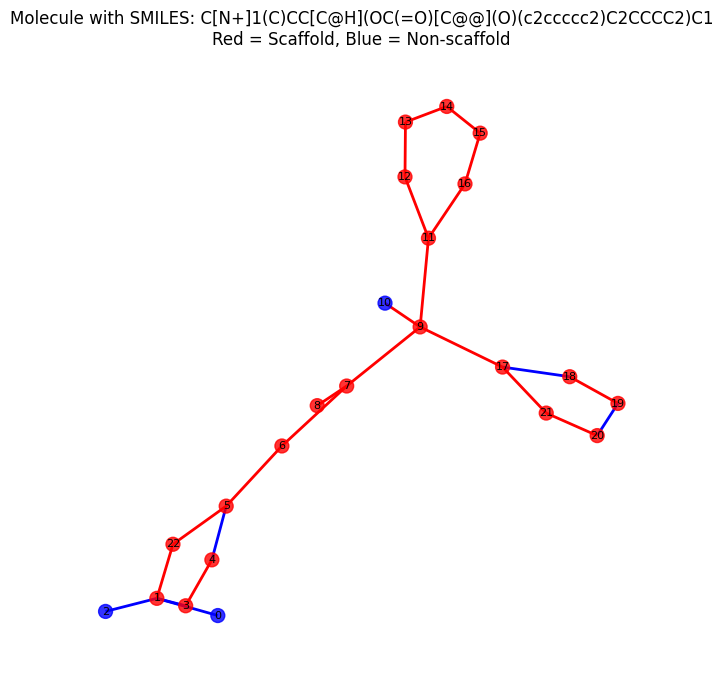

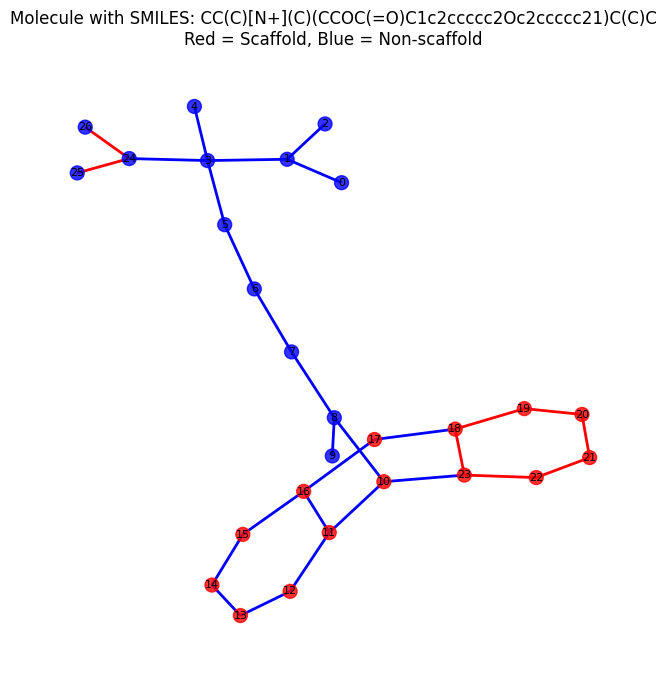

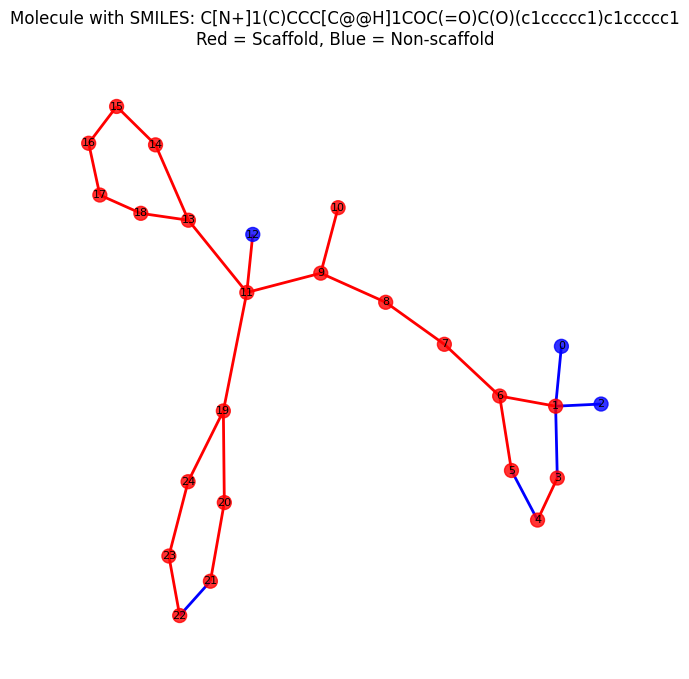

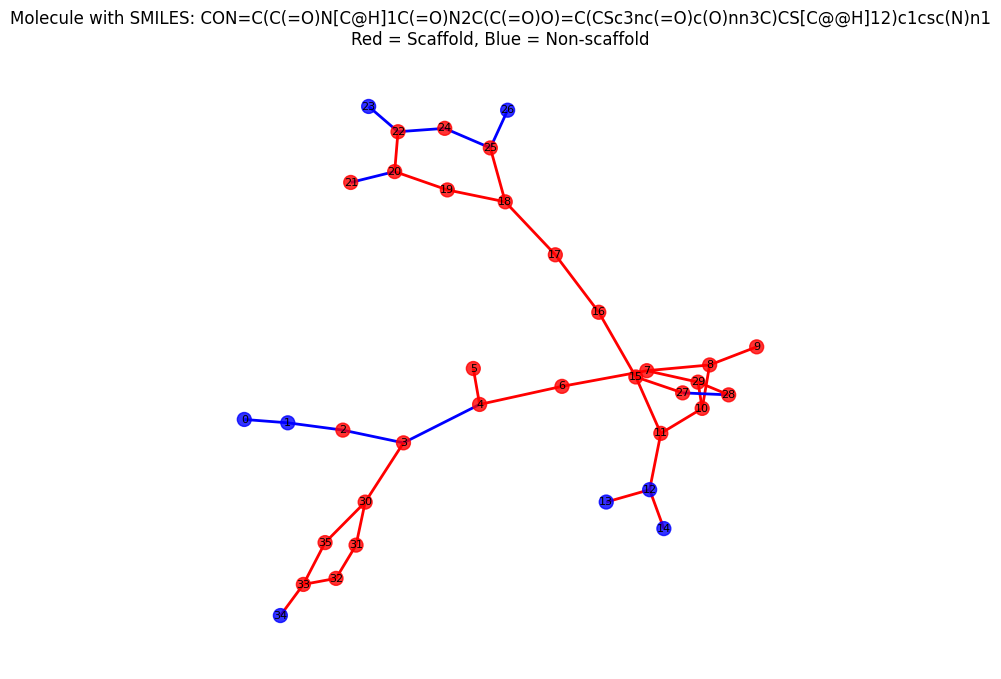

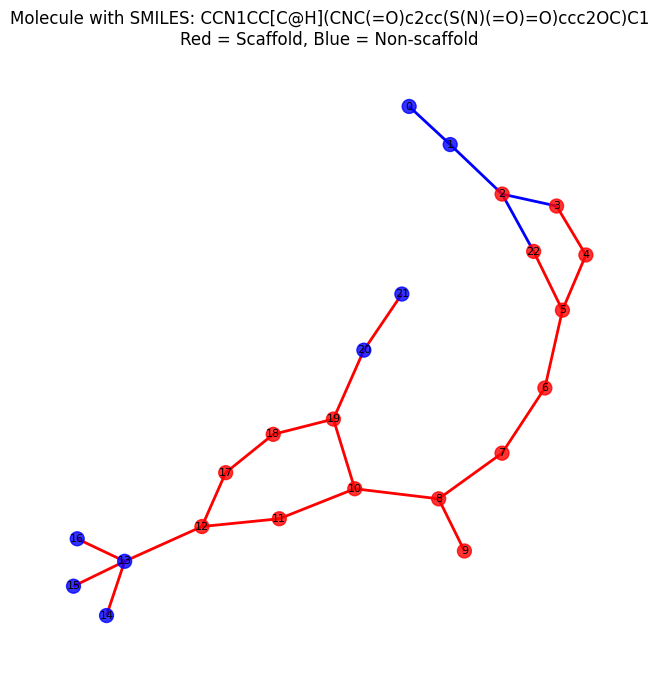

In [12]:
## Visualize scaffold mask

for i in range(5):
    visualize_scaffold_mask(selected_data[i], sampled_smiles[i])
    

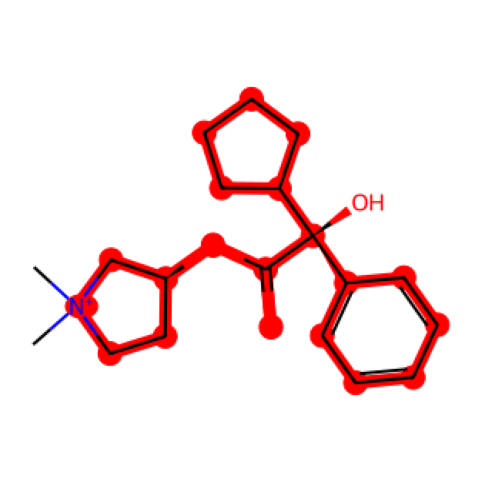

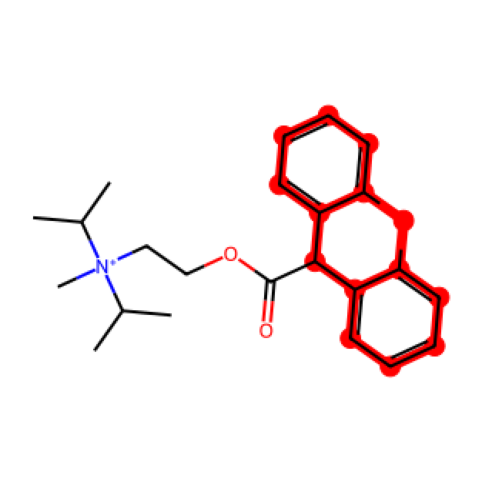

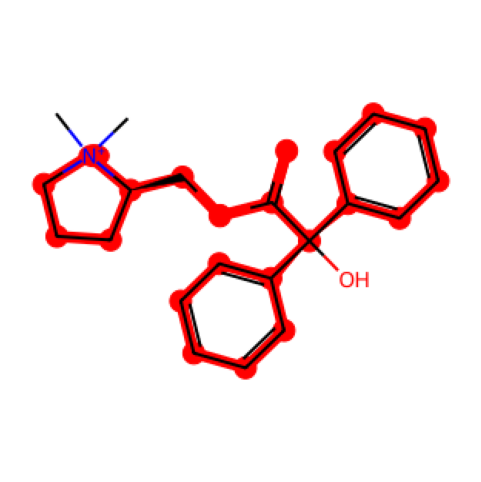

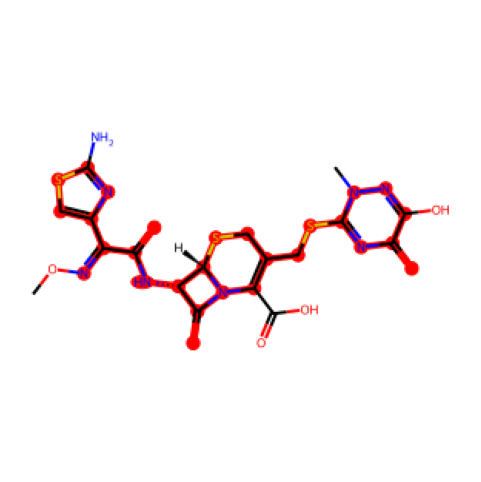

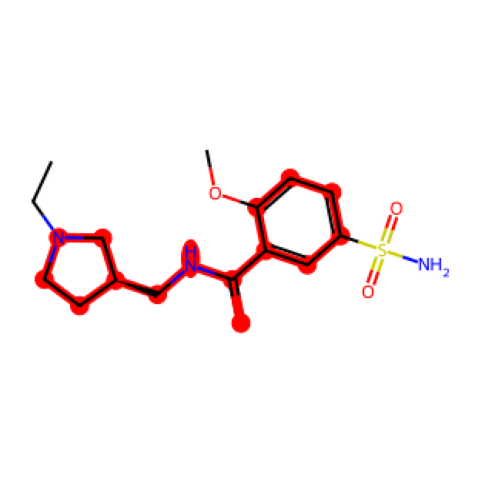

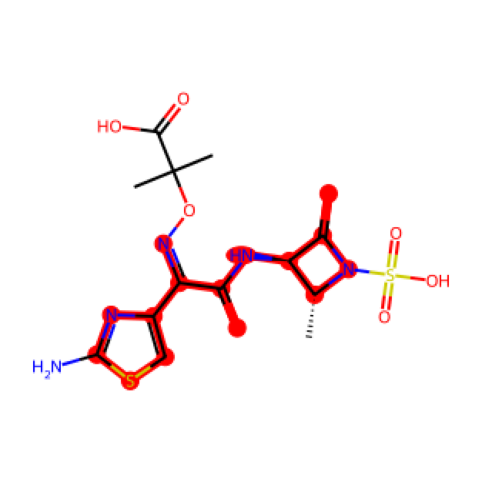

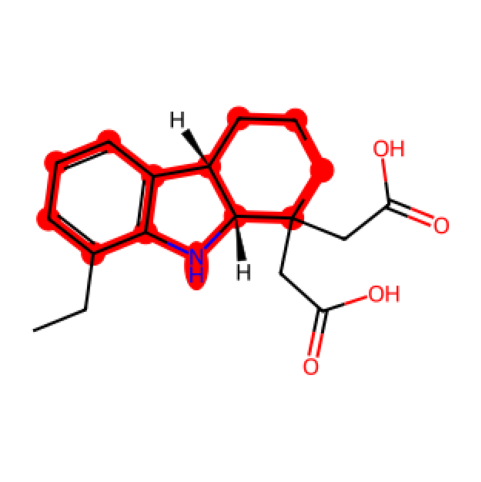

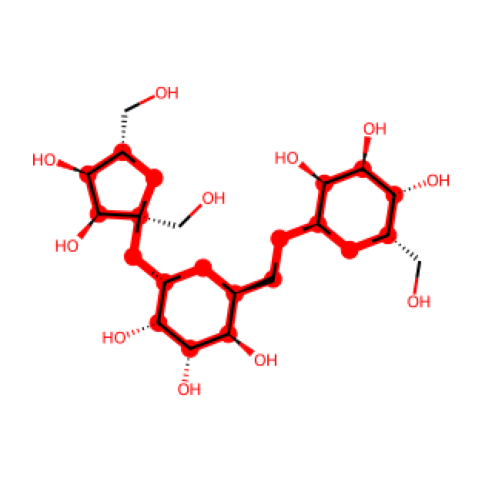

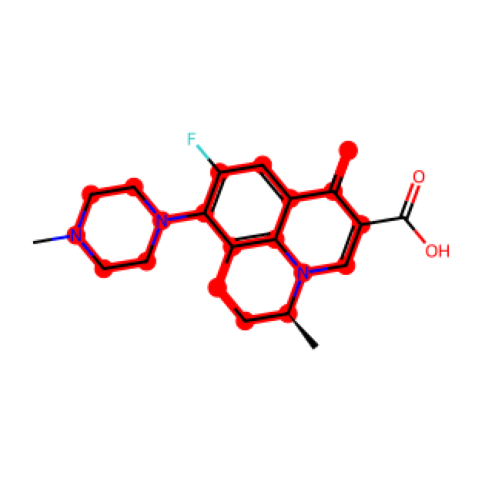

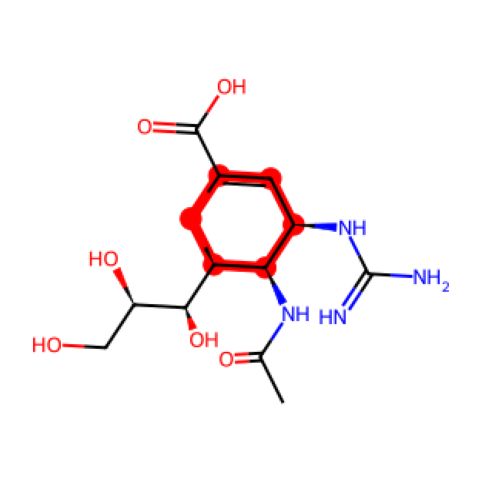

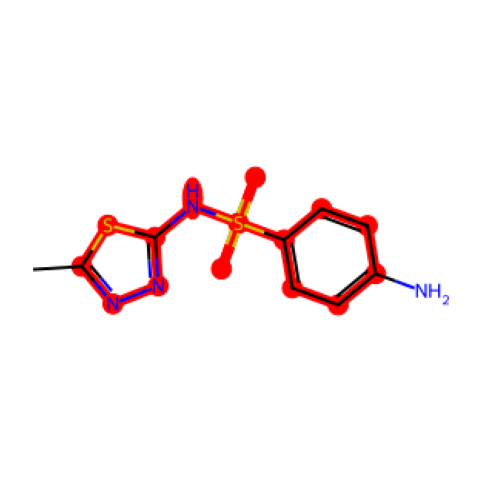

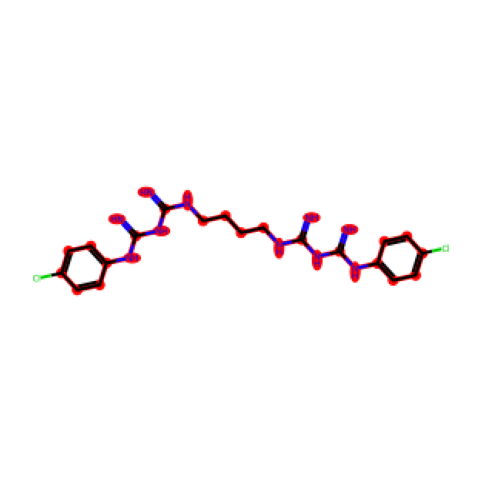

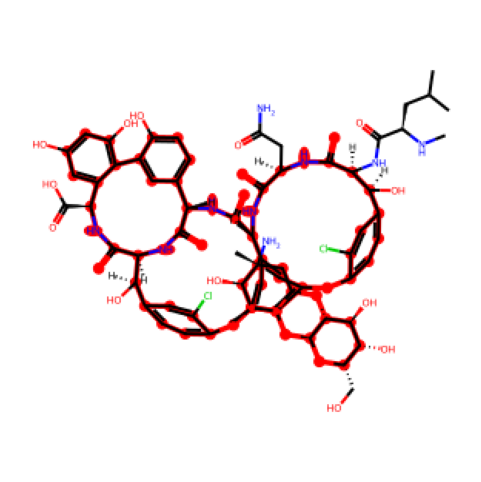

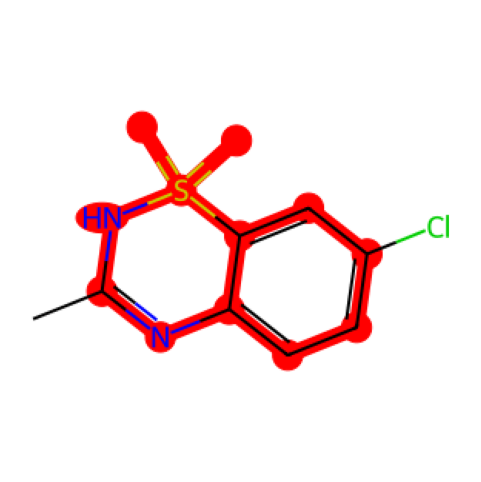

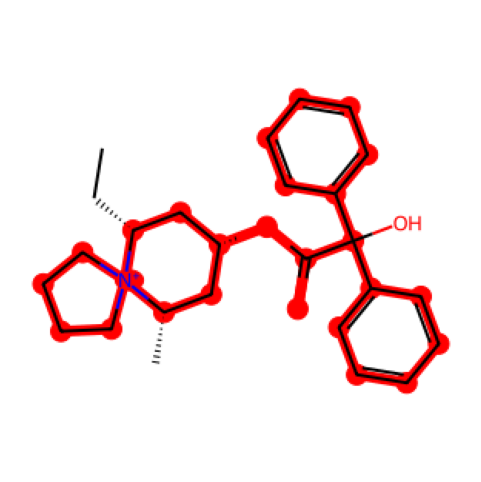

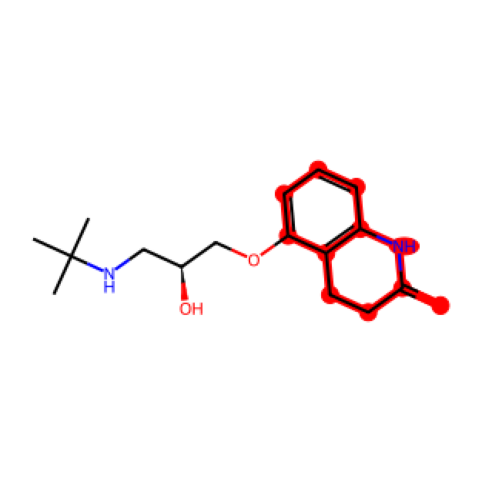

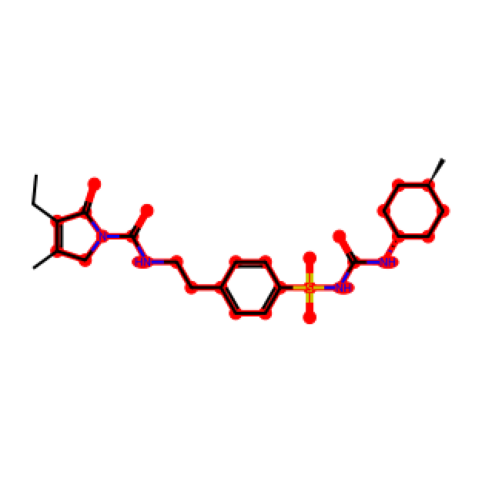

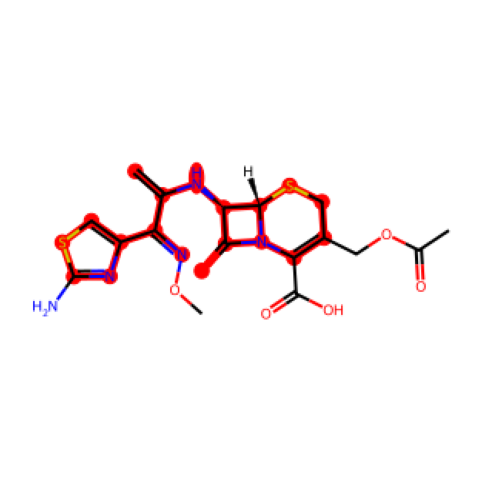

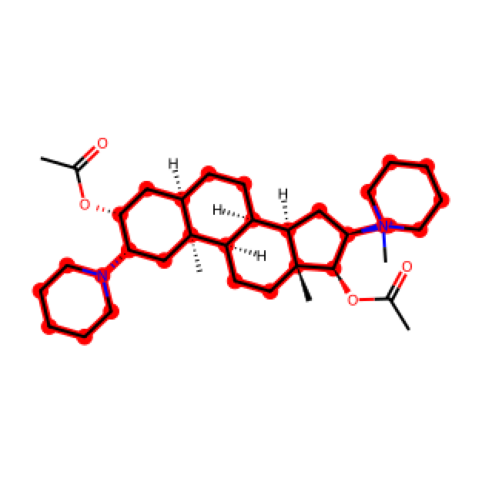

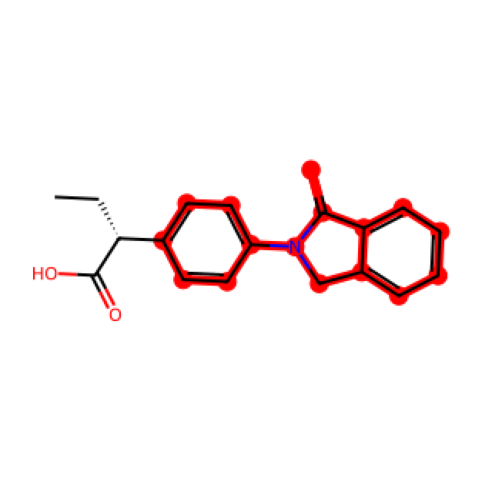

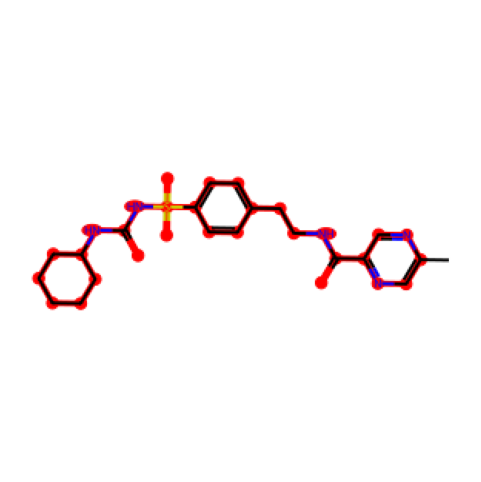

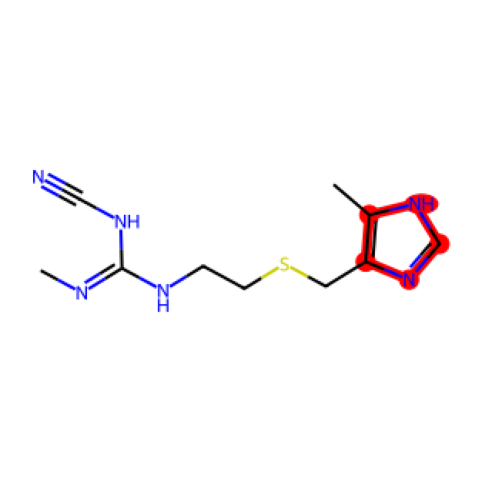

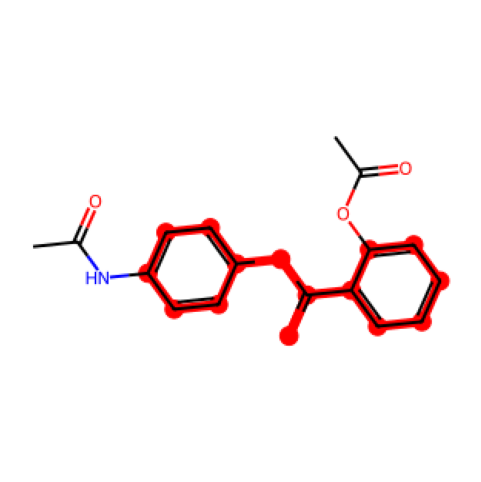

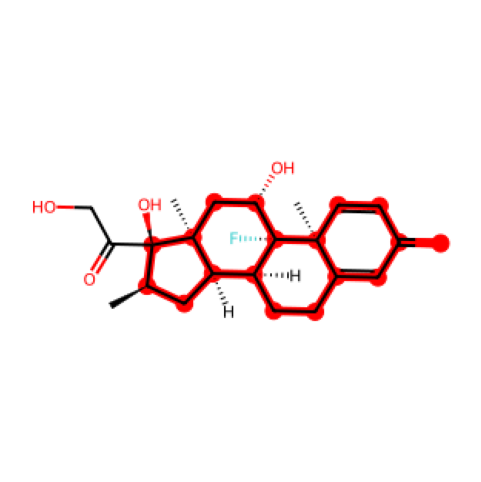

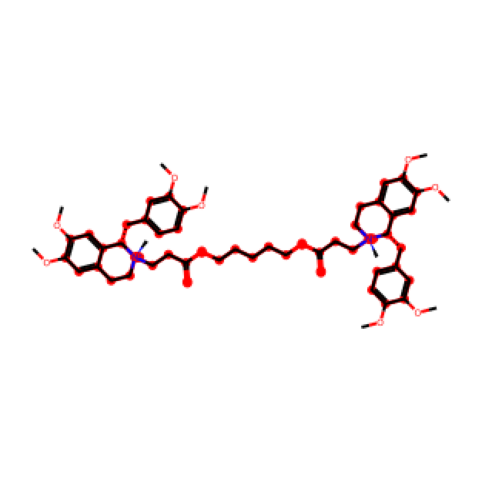

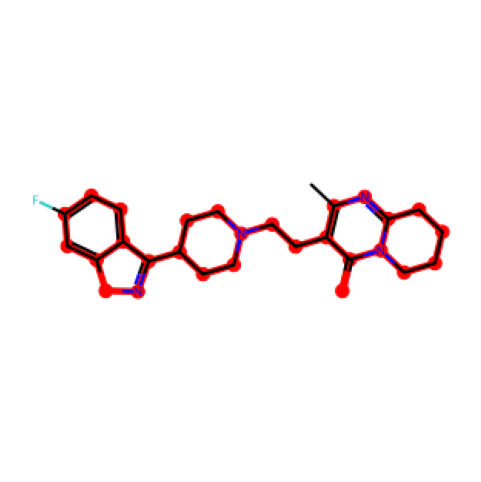

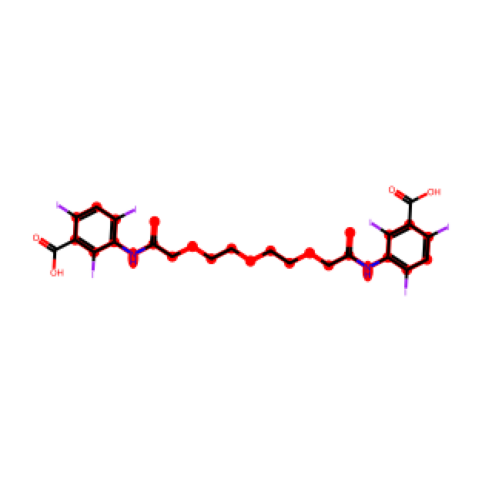

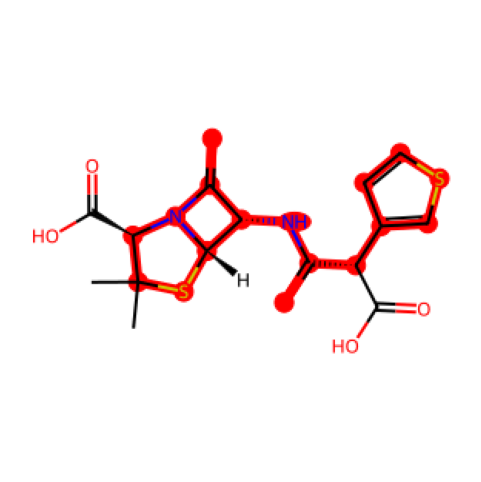

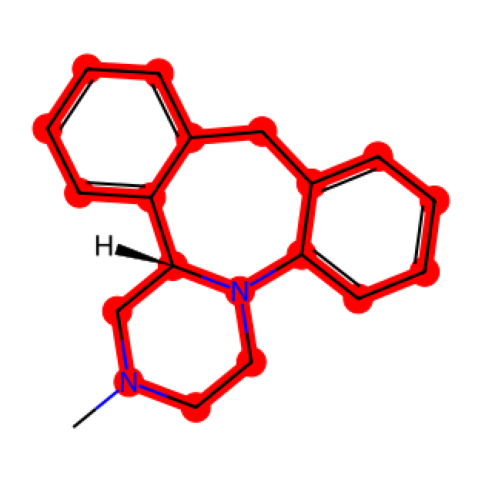

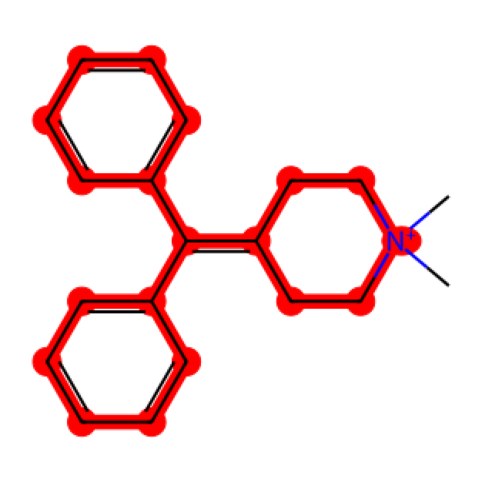

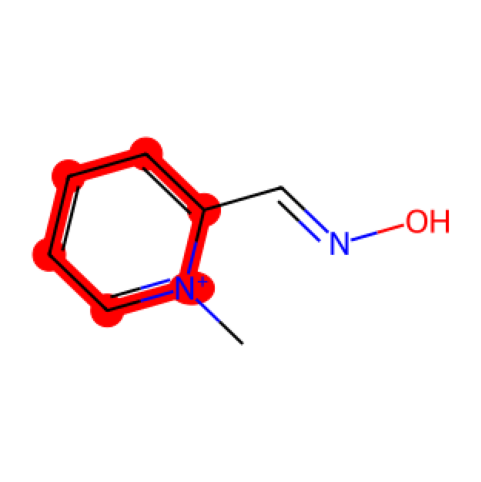

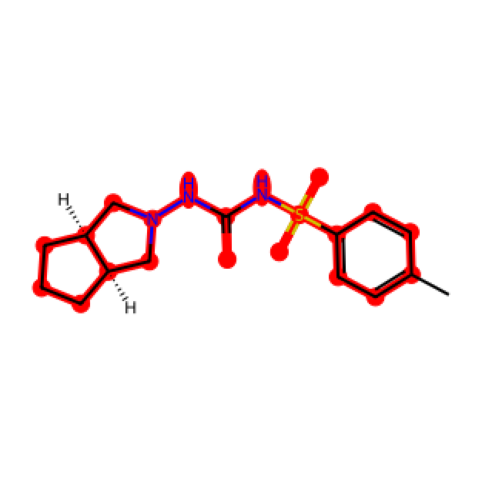

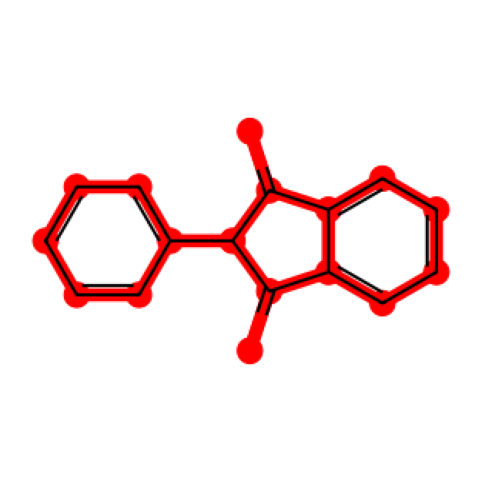

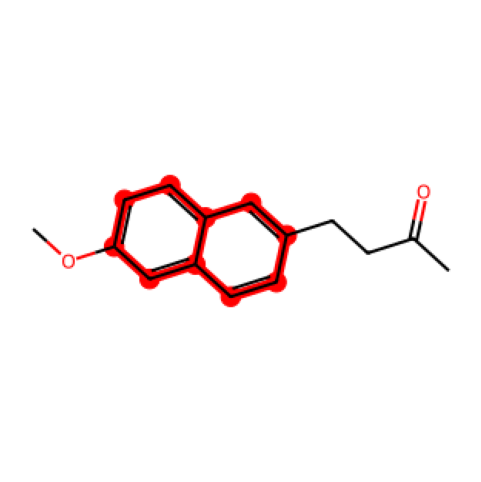

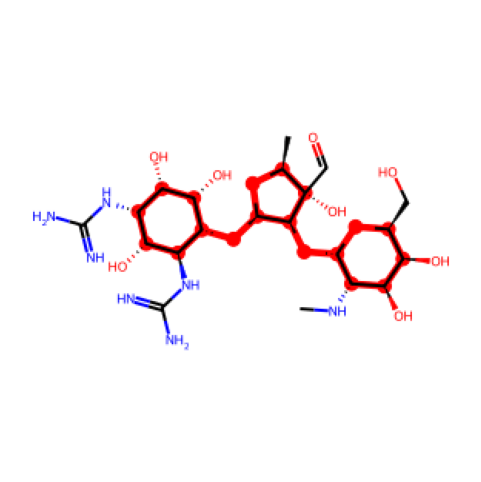

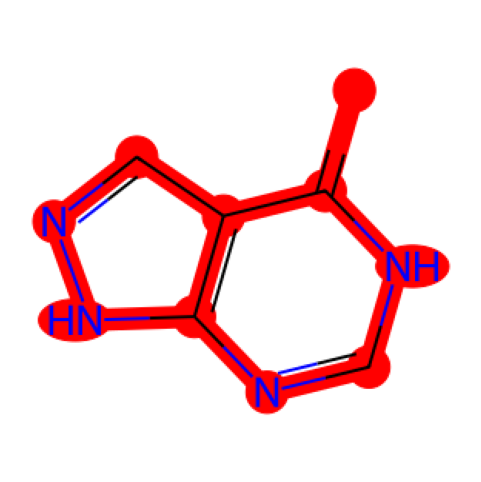

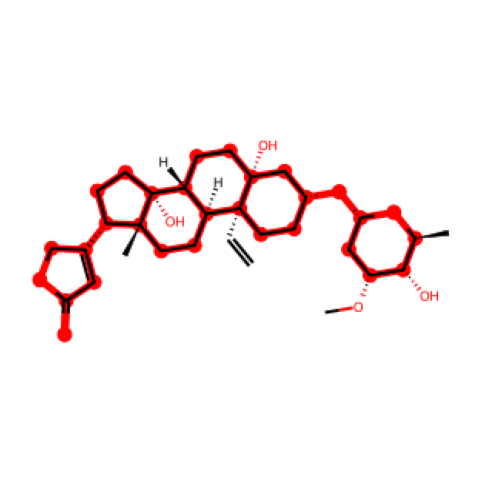

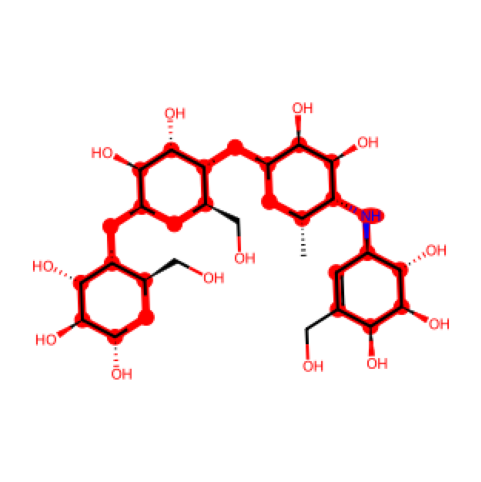

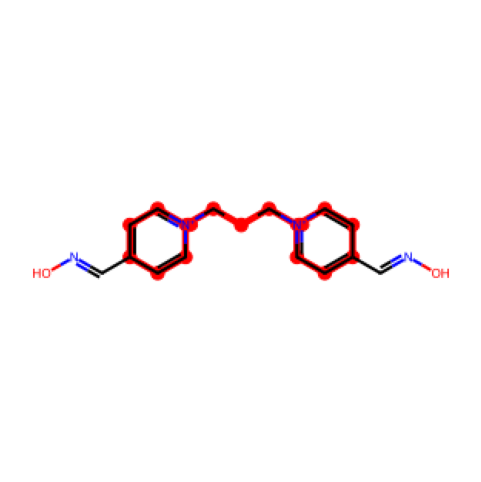

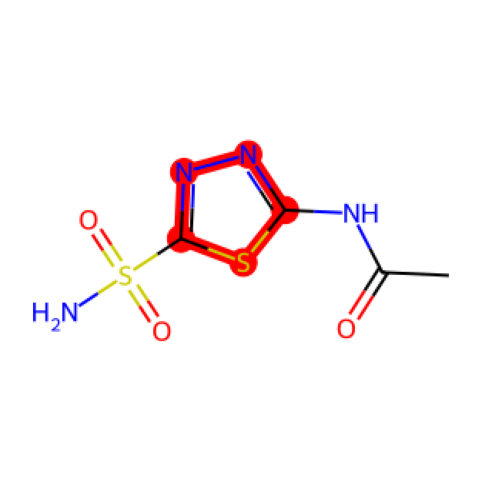

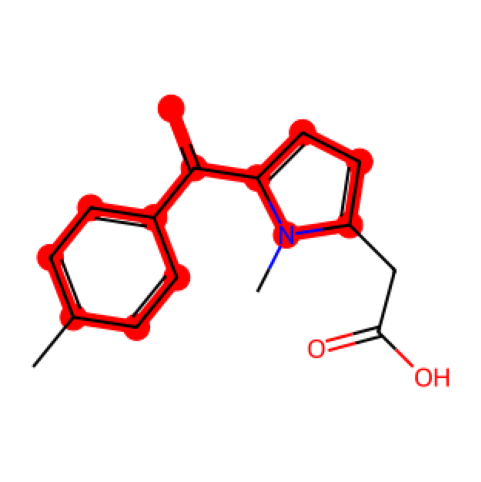

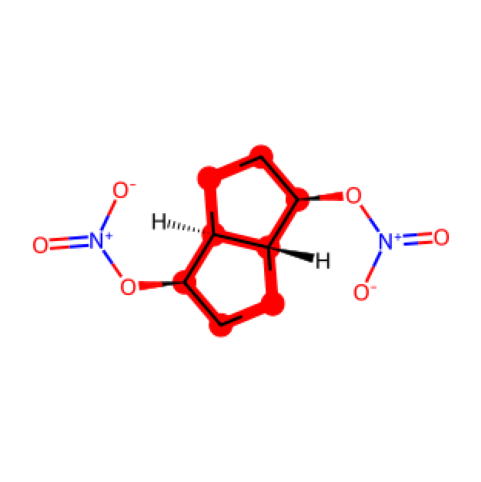

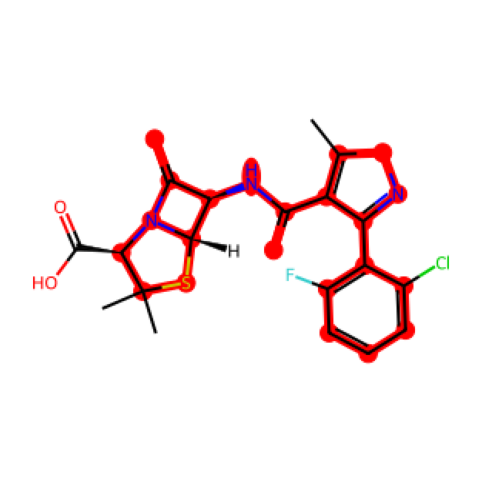

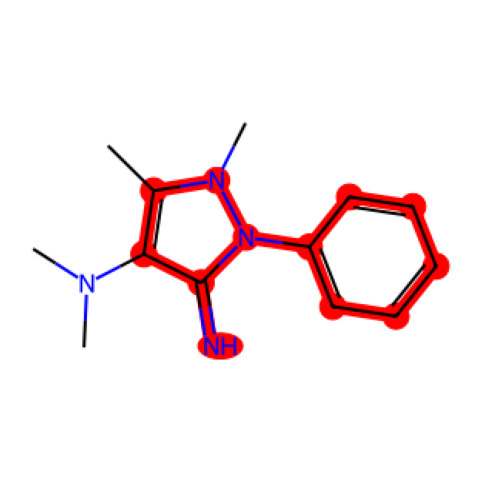

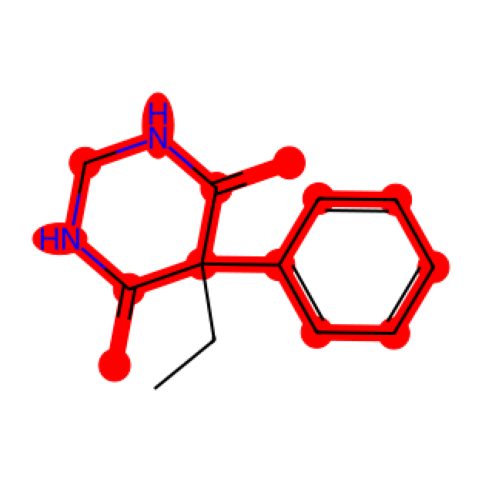

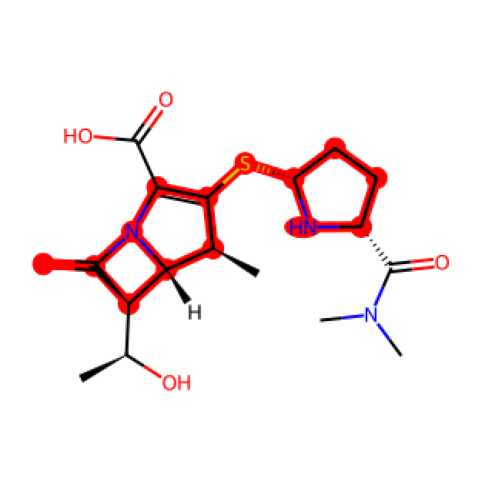

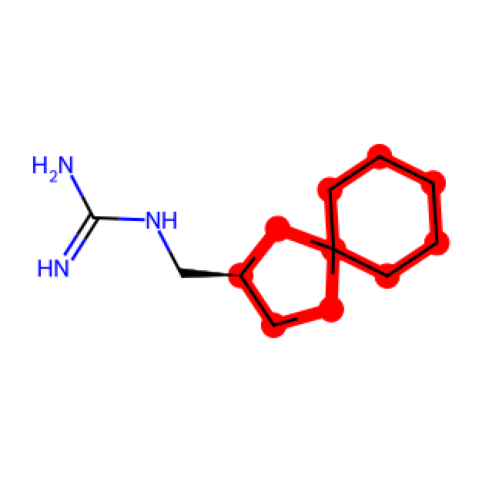

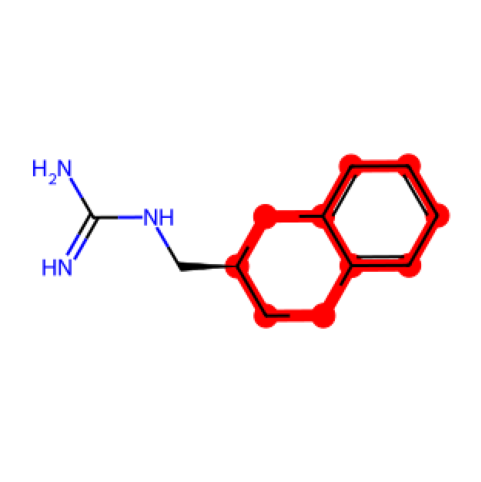

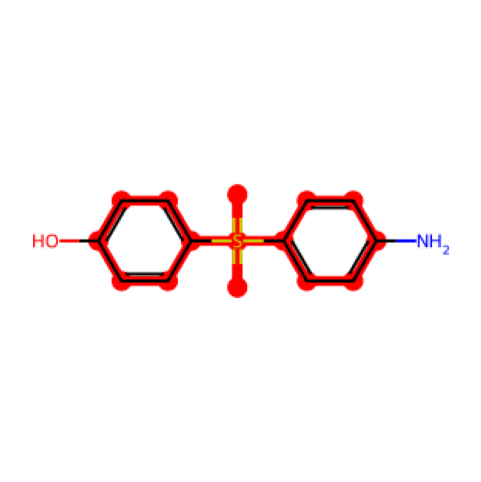

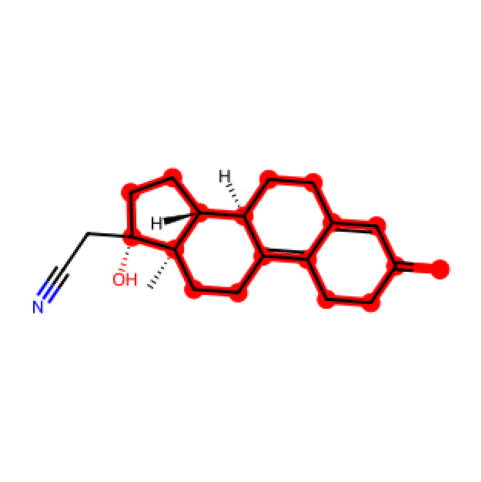

In [19]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold

def plot_molecule_with_scaffold(smiles):
    """
    Plots the molecule represented by a SMILES string, highlighting the scaffold in the figure.
    :param smiles: SMILES string of the molecule.
    """
    # print(smiles)
    # Generate molecule and scaffold
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    
    # Generate the scaffold
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    if scaffold is None:
        raise ValueError(f"No scaffold found for SMILES: {smiles}")
    
    # Get atom and bond indices for the scaffold
    scaffold_indices = mol.GetSubstructMatch(scaffold)
    if not scaffold_indices:
        raise ValueError(f"Cannot match scaffold substructure in SMILES: {smiles}")
    
    # Highlight scaffold atoms and bonds
    atom_highlights = list(scaffold_indices)
    bond_highlights = []
    for bond in scaffold.GetBonds():
        start = scaffold_indices[bond.GetBeginAtomIdx()]
        end = scaffold_indices[bond.GetEndAtomIdx()]
        bond_idx = mol.GetBondBetweenAtoms(start, end).GetIdx()
        bond_highlights.append(bond_idx)
    
    # Draw the molecule with highlighted scaffold
    img = Draw.MolToImage(mol, highlightAtoms=atom_highlights, highlightBonds=bond_highlights, highlightColor=(1, 0, 0))
    
    # Create a figure and add the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    # plt.title(f"SMILES: {smiles}")
    plt.axis("off")
    plt.show()

for i in range(50):
    plot_molecule_with_scaffold(sampled_smiles[i])
